### Useful links
[DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning](http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/)

[RDKit_Overview](http://www.rdkit.org/RDKit_Overview.pdf)

[Feature scaling](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [1]:
from collections import namedtuple

import pandas
import numpy
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
dataset_read = pandas.read_excel("dataset.xlsx")

# Trim Wang's (2015) predicted values since we are calculating these ourselves
dataset = dataset_read.iloc[:,0:4]
results = dataset_read.iloc[:,4:]

In [3]:
# From the main dataset, split into training and test dataframes
training_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"]
test_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Te"]

print("Training set has {} items, test set has {} items".format(training_set.iloc[:,0].count(), test_set.iloc[:,0].count()))

Training set has 904 items, test set has 226 items


In [4]:
training_set.head()

,NO,Tr=traning set Te=test set,SMILES structure,experimental logD7.4
1,A-logD7.4-100,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1,-0.96
2,A-logD7.4-101,Tr,S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1,-0.92
3,A-logD7.4-104,Tr,OC=1C(=O)C=CN(CCCO)C=1C,-0.90
4,A-logD7.4-105,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)c2ccccc2C)cc1N1CCNCC1,-0.83
5,A-logD7.4-106,Tr,OC=1C(=O)C=CN(CCC(=O)NCC)C=1C,-0.82


## Fingerprinting molecules
    A way to encode and represent molecules in a format that 1) makes it easy to compare how similar or different two molecules 2) uniquely identify that molecule 3) allow for a quick and efficent search of the molecule's sub-structure.
    
    Fingerprinting is a technique traditionally used for molecule search and screening in large chemoinformatic databases, where many comparisons must be made a second. In this project, I'm hoping to use these techniques as a way to uniquely encode a molecule in a way that is easy to feed into a ML algorithm while also retaining the specific features/descriptors of that molecule which may contribute to its lipophillicity.

    Essentially a hash.

#### Quick bit on fingerprints vs structural keys
    "A fingerprint is a boolean array, or bitmap, but unlike a structural key there is no assigned meaning to each bit. Your own fingerprint is very characteristic of you, yet there is no meaning to any particular feature. Similarly, a pattern's fingerprint characterizes the pattern, but the meaning of any particular bit is not well defined... In spite of the difference between the meaning of a fingerprint's bits and a structural key's bits, fingerprints share an important feature with structural keys: If a pattern is a substructure of a molecule, every bit that is set in the pattern's fingerprint will be set in the molecule's fingerprint."
        
[Source](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)

### Which fingerprint should I use?
    Good q, just gonna pick one and run with it. I'll come back to see if theres a better fitting one later.
[Possible source](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)
 

## Experiment with RDKit on single molecule

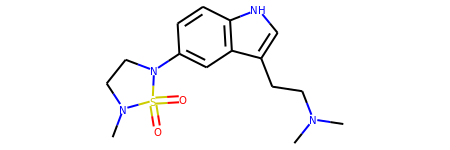

In [5]:
# taking SMILE from `training_set['SMILES structure'].iloc[1]`, creating a molecule object
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')
# Draw the molecule
molecule

## Back to working with training_set

In [6]:
fpSize=4096

In [7]:
xytuple = namedtuple('xytuple', ['x', 'y'])

def df_to_xy(df):
    ### return numpy of arrays
    # Make an arr of lipophillicity values
    lip_arr = df['experimental logD7.4'].values
    # Make an arr of fingerprints
    mol_series = df['SMILES structure'].apply(Chem.MolFromSmiles)
    RDK_fp_series = mol_series.apply(lambda mol: numpy.array(RDKFingerprint(mol, fpSize=fpSize)))
    RDK_fp_arr = numpy.matrix(RDK_fp_series.tolist())
    return xytuple(x=RDK_fp_arr, y=lip_arr)
    

In [8]:
### Prepare training set and test set to feed into ml algo
X_train, y_train = df_to_xy(training_set)
X_test, y_test = df_to_xy(test_set)

# Data normalization/scaling
#not sure if normalization is really needed here, considering its a 0-1 feature vector
from sklearn.preprocessing import Normalizer, StandardScaler
n_scale = Normalizer().fit(X_train)
X_train_n = n_scale.transform(X_train)
X_test_n  = n_scale.transform(X_test)
std_scale = StandardScaler().fit(X_train_n)
X_train_std = std_scale.transform(X_train_n)
X_test_std  = std_scale.transform(X_test_n)

enviorment_data = namedtuple('enviorment_data', ['X_train', 'y_train', 'X_test', 'y_test'])

env = enviorment_data(X_train=X_train_std, y_train=y_train, X_test=X_test_std, y_test=y_test)
# env = enviorment_data(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Testing regression models

In [9]:
class color:
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def test_model(model, name, data=env):
    print("\n{}{}{}{}\n".format(color.BOLD,color.UNDERLINE,name,color.END))
    model.fit(data.X_train, data.y_train)

    # predict on the unseen dataset
    y_pred_train = model.predict(data.X_train)
    y_pred = model.predict(data.X_test)
    mse = mean_squared_error(y_pred, data.y_test)
    mse_train = mean_squared_error(y_pred_train, data.y_train)
    rmse = numpy.sqrt(mse)
    r2 = model.score(data.X_test, data.y_test)

    # R-squared is a goodness-of-fit measubre for linear regression models, how much variance of the data vs our model
    # Explained variance score: 1 is perfect prediction
    print("{}r^2:{} {:.3f}".format(color.BOLD, color.END, r2))
    print('{}RMSE:{} {:.3f}'.format(color.BOLD, color.END, rmse))
    # We want a low mse
    print("{}MSE train:{} {:.3f}".format(color.BOLD, color.END, mse_train))
    print("{}MSE test:{} {:.3f}".format(color.BOLD, color.END, mse))
    
    print('So, in our model, {:.2f}% of the variability in Y can be explained using X. '.format(model.score(data.X_test, data.y_test)*100))
    print('Our model predicted most of the lipophilicity values in the test set within {:.2f} of the real value.'.format(rmse))


    # Plot outputs training data
    plt.scatter(data.y_train, y_pred_train, c='b',s=40, alpha=.5)
    # Plot outputs test data
    plt.scatter(data.y_test,y_pred, c='g',s=40, alpha=.5)
    plt.xlabel("Actual lipo")
    plt.ylabel("Predicted lipo")
    plt.show()
    plt.scatter(model.predict(data.X_train), model.predict(data.X_train)-data.y_train, c='b',s=40, alpha=.5)
    plt.scatter(model.predict(data.X_test), model.predict(data.X_test)-data.y_test, c='g',s=40, alpha=.5)
#     plt.hlines(y=0, xmin=-10, xmax=15)
    plt.title("Residual plot using training(blue) and test(green) data")
    plt.ylabel("Residuals")
    return model


Linear Regression with Ridge regularizaton

r^2: 0.80
RMSE: 0.76
MSE train: 0.18
MSE test: 0.58
So, in our model, 79.73% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.76 of the real value.


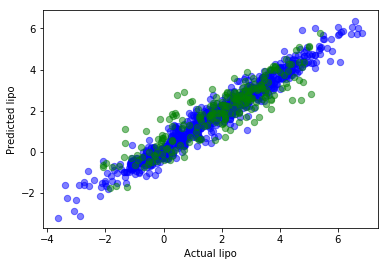

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=None, solver='auto', tol=0.001)

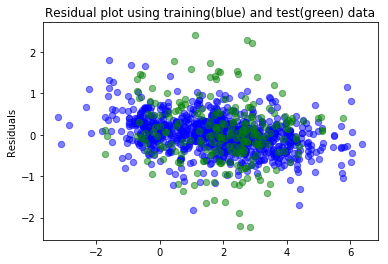

In [10]:
from sklearn.linear_model import Ridge
test_model(Ridge(alpha=1, 
                 normalize=True,
                ), "Linear Regression with Ridge regularizaton")


Linear Regression with Lasso regularizaton

r^2: 0.74
RMSE: 0.87
MSE train: 0.37
MSE test: 0.75
So, in our model, 73.61% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.87 of the real value.


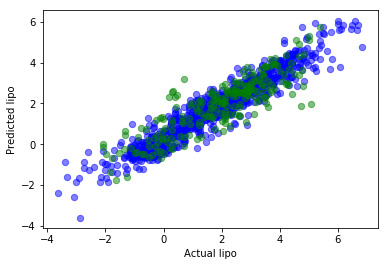

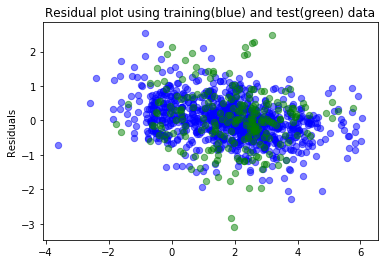

In [11]:
from sklearn.linear_model import Lasso
model = test_model(Lasso(alpha=.001,# constant that multiplies L1 term
                         normalize=True), "Linear Regression with Lasso regularizaton")


SVM Regression

r^2: 0.77
RMSE: 0.82
MSE train: 0.02
MSE test: 0.67
So, in our model, 76.58% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.82 of the real value.


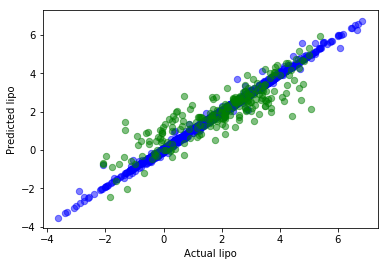

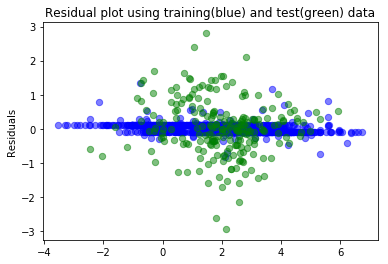

In [12]:
from sklearn.svm import SVR
svm_model = SVR(
    ## tune hyperparams
    kernel='rbf', 
    C=10, #regularization parameter, smaller values are larger margins
#     gamma =.001, # small val -> include far data points, large -> only those close to margin
)
model = test_model(svm_model, "SVM Regression")

In [13]:
#Testing one molecule
### return numpy of arrays
actual_lip = [-0.92]
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')
# Lets generate a rdk fingerprint from the molecule, which is really a DataStructs.ExplicitBitVect
RDK_fp = RDKFingerprint(molecule, fpSize=fpSize)
RDK_fp = numpy.matrix(numpy.array(RDK_fp))
fp_n = n_scale.transform(RDK_fp)
fp_std = std_scale.transform(fp_n)

model.predict(fp_std)

array([-0.81955876])